In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import zipfile

from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import roc_auc_score
from sklearn.base import clone
from sklearn.model_selection import KFold

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import RepeatedKFold,GridSearchCV

In [2]:
## Reading the csv file directly from the zip file without extracting it

archive = zipfile.ZipFile('../02_Data/hotel_bookings_ohe.csv.zip', 'r')
files = archive.namelist()
with archive.open(files[0]) as csvfile:   
    df = pd.read_csv(csvfile)

In [3]:
df.head(5)

,arrival_date_year,adults,children,babies,previous_cancellations,booking_changes,total_of_special_requests,log_lead_time,total_nights,previous_bookings,...,market_segment_Online TA,market_segment_Undefined,meal_BB,meal_FB,meal_HB,meal_SC,meal_Undefined,required_car_parking_0,required_car_parking_1,is_canceled
0,2015,2,0,0,0,3,0,5.837730,0,0,...,0,0,1,0,0,0,0,1,0,0
1,2015,2,0,0,0,4,0,6.603944,0,0,...,0,0,1,0,0,0,0,1,0,0
2,2015,1,0,0,0,0,0,2.079442,1,0,...,0,0,1,0,0,0,0,1,0,0
3,2015,1,0,0,0,0,0,2.639057,1,0,...,0,0,1,0,0,0,0,1,0,0
4,2015,2,0,0,0,0,1,2.708050,2,0,...,1,0,1,0,0,0,0,1,0,0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119388 entries, 0 to 119387
Data columns (total 66 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   arrival_date_year              119388 non-null  int64  
 1   adults                         119388 non-null  int64  
 2   children                       119388 non-null  int64  
 3   babies                         119388 non-null  int64  
 4   previous_cancellations         119388 non-null  int64  
 5   booking_changes                119388 non-null  int64  
 6   total_of_special_requests      119388 non-null  int64  
 7   log_lead_time                  119388 non-null  float64
 8   total_nights                   119388 non-null  int64  
 9   previous_bookings              119388 non-null  int64  
 10  log_days_in_waiting_list       119388 non-null  float64
 11  log_adr                        119388 non-null  float64
 12  arrival_month_1               

In [3]:
numerical_cols = ['arrival_date_year', 'adults', 'children', 'babies',
       'previous_cancellations', 'booking_changes',
       'total_of_special_requests', 'log_lead_time', 'total_nights',
       'previous_bookings', 'log_days_in_waiting_list', 'log_adr']

cat_cols = [col for col in df.columns if col not in numerical_cols]


In [4]:
# get train indexes
train_ind = pd.read_csv("../02_Data/train_index.csv")

# split train
train = df.iloc[train_ind.Train_Index,:]
train.reset_index(inplace = True, drop = True)

# Split test 
test = df.iloc[df.index.difference(train_ind.Train_Index),:]

In [5]:
## Standardising the numerical columns
df_train_std = train.copy()
df_test_std = test.copy()

sc = StandardScaler().fit(df_train_std[numerical_cols])
df_train_std[numerical_cols] = sc.transform(df_train_std[numerical_cols])
 
df_test_std[numerical_cols] = sc.transform(df_test_std[numerical_cols])

### Fitting a neural network model with all features

In [6]:
## Creating the X and y variables

X_train = df_train_std.drop("is_canceled",axis=1)
y_train = df_train_std["is_canceled"]

X_test = df_test_std.drop("is_canceled",axis=1)
y_test = df_test_std["is_canceled"]

In [7]:
# define a neural network model with stochastic optimizer
np.random.seed(456)

clf_init = MLPClassifier(
    ## archiecture hyperparameters ## 
    hidden_layer_sizes=20, # scalar -> single hidden layer with 20 units
    activation='logistic', # activation function for the hidden layer
    alpha=1e-4,# regularization parameter,
    solver='adam', # stochastic optimizer (default)
    learning_rate_init=0.01,# learning rate, controls the step size
    batch_size=512, # the number of samples considered in each iteration
    max_iter = 300, # number of epochs through the training set,
    #early_stopping=True, # monitor validation_loss and stop if there is no improvement
    #n_iter_no_change=10, # if validation loss doesn't improve for 10 epochs, terminate optimization
    #validation_fraction=0.1, # fraction of the dataset to set as aside as validation data
    verbose=False,
    random_state=456
)

# fit model
clf_init.fit(X_train,y_train)

MLPClassifier(activation='logistic', batch_size=512, hidden_layer_sizes=20,
              learning_rate_init=0.01, max_iter=300, random_state=456)

In [9]:
y_pred_class = clf_init.predict(X_test)

In [10]:
## Calculating the roc

conf_matrix = confusion_matrix(y_test, y_pred_class)


print('AUC score is ',roc_auc_score(y_test,y_pred_class))
misclass = (conf_matrix[0][1]+conf_matrix[1][0])/(sum(sum(conf_matrix)))
print('Misclass rate is ',misclass)

# --- Metrics---

print('\n--- EVALUATION METRICS ---:')
print('\nConfusion Matrix:')
print(conf_matrix)

print('\nClassification Report:')

print(classification_report(y_test,y_pred_class))


AUC score is  0.8502906891407417
Misclass rate is  0.13364325501528668

--- EVALUATION METRICS ---:

Confusion Matrix:
[[13724  1325]
 [ 1866  6962]]

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.91      0.90     15049
           1       0.84      0.79      0.81      8828

    accuracy                           0.87     23877
   macro avg       0.86      0.85      0.85     23877
weighted avg       0.87      0.87      0.87     23877



### Performing Gridsearch CV

In [7]:
np.random.seed(3)

clf_cv_init = MLPClassifier(
    ## archiecture hyperparameters ## 
    #hidden_layer_sizes=20, # scalar -> single hidden layer with 20 units
    activation='logistic', # activation function for the hidden layer
    #alpha=1e-4,# regularization parameter,
    solver='adam', # stochastic optimizer (default)
    #learning_rate_init=0.01,# learning rate, controls the step size
    batch_size=512, # the number of samples considered in each iteration
    max_iter = 500, # number of epochs through the training set,
    #early_stopping=True, # monitor validation_loss and stop if there is no improvement
    #n_iter_no_change=10, # if validation loss doesn't improve for 10 epochs, terminate optimization
    #validation_fraction=0.1, # fraction of the dataset to set as aside as validation data,
    random_state=3,
    verbose=False
)

clf_final = GridSearchCV(
    estimator = clf_cv_init,
    param_grid = { # dictionary containing possible values of each hyperparameter
        'alpha':[1e-4,1e-3,1e-1],
        'hidden_layer_sizes':[10,20,30],
        'learning_rate_init':[1e-3,1e-2,1e-1]
    },
    scoring='accuracy', # scoring metric - prediction accuracy
    refit=True,
    cv = KFold(n_splits=5,shuffle=True), # 1 replicate of 5-fold CV
    verbose=3
).fit(X_train,y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV 1/5] END alpha=0.0001, hidden_layer_sizes=10, learning_rate_init=0.001;, score=0.856 total time=  14.5s
[CV 2/5] END alpha=0.0001, hidden_layer_sizes=10, learning_rate_init=0.001;, score=0.856 total time=  19.6s
[CV 3/5] END alpha=0.0001, hidden_layer_sizes=10, learning_rate_init=0.001;, score=0.857 total time=  13.4s
[CV 4/5] END alpha=0.0001, hidden_layer_sizes=10, learning_rate_init=0.001;, score=0.861 total time=  12.1s
[CV 5/5] END alpha=0.0001, hidden_layer_sizes=10, learning_rate_init=0.001;, score=0.857 total time=  13.1s
[CV 1/5] END alpha=0.0001, hidden_layer_sizes=10, learning_rate_init=0.01;, score=0.860 total time=   7.4s
[CV 2/5] END alpha=0.0001, hidden_layer_sizes=10, learning_rate_init=0.01;, score=0.859 total time=   9.6s
[CV 3/5] END alpha=0.0001, hidden_layer_sizes=10, learning_rate_init=0.01;, score=0.857 total time=   7.9s
[CV 4/5] END alpha=0.0001, hidden_layer_sizes=10, learning_rate_init=0.01;, s

[CV 3/5] END alpha=0.001, hidden_layer_sizes=30, learning_rate_init=0.001;, score=0.864 total time=  41.1s
[CV 4/5] END alpha=0.001, hidden_layer_sizes=30, learning_rate_init=0.001;, score=0.868 total time=  33.5s
[CV 5/5] END alpha=0.001, hidden_layer_sizes=30, learning_rate_init=0.001;, score=0.866 total time=  45.3s
[CV 1/5] END alpha=0.001, hidden_layer_sizes=30, learning_rate_init=0.01;, score=0.861 total time=  19.2s
[CV 2/5] END alpha=0.001, hidden_layer_sizes=30, learning_rate_init=0.01;, score=0.861 total time=  24.5s
[CV 3/5] END alpha=0.001, hidden_layer_sizes=30, learning_rate_init=0.01;, score=0.864 total time=  26.4s
[CV 4/5] END alpha=0.001, hidden_layer_sizes=30, learning_rate_init=0.01;, score=0.864 total time=  15.5s
[CV 5/5] END alpha=0.001, hidden_layer_sizes=30, learning_rate_init=0.01;, score=0.867 total time=  17.5s
[CV 1/5] END alpha=0.001, hidden_layer_sizes=30, learning_rate_init=0.1;, score=0.858 total time=   5.0s
[CV 2/5] END alpha=0.001, hidden_layer_sizes

In [8]:
print('Best parameters')
print(clf_final.best_params_)

print('Best CV accuracy: %.3f'%clf_final.best_score_)

Best parameters
{'alpha': 0.001, 'hidden_layer_sizes': 30, 'learning_rate_init': 0.001}
Best CV accuracy: 0.865


In [9]:
### Testing with test dataset

y_pred_class = clf_final.predict(X_test)

## Calculating the roc

conf_matrix = confusion_matrix(y_test, y_pred_class)


print('AUC score is ',roc_auc_score(y_test,y_pred_class))
misclass = (conf_matrix[0][1]+conf_matrix[1][0])/(sum(sum(conf_matrix)))
print('Misclass rate is ',misclass)

# --- Metrics---

print('\n--- EVALUATION METRICS ---:')
print('\nConfusion Matrix:')
print(conf_matrix)

print('\nClassification Report:')

print(classification_report(y_test,y_pred_class))


AUC score is  0.8490308414954887
Misclass rate is  0.13322444193156593

--- EVALUATION METRICS ---:

Confusion Matrix:
[[13802  1247]
 [ 1934  6894]]

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.92      0.90     15049
           1       0.85      0.78      0.81      8828

    accuracy                           0.87     23877
   macro avg       0.86      0.85      0.85     23877
weighted avg       0.87      0.87      0.87     23877



### Second trial with increasing nodes

In [10]:
## Second batch

np.random.seed(3)

clf_cv_init = MLPClassifier(
    ## archiecture hyperparameters ## 
    #hidden_layer_sizes=20, # scalar -> single hidden layer with 20 units
    activation='logistic', # activation function for the hidden layer
    #alpha=1e-4,# regularization parameter,
    solver='adam', # stochastic optimizer (default)
    learning_rate_init=0.001,# learning rate, controls the step size
    batch_size=512, # the number of samples considered in each iteration
    max_iter = 500, # number of epochs through the training set,
    #early_stopping=True, # monitor validation_loss and stop if there is no improvement
    #n_iter_no_change=10, # if validation loss doesn't improve for 10 epochs, terminate optimization
    #validation_fraction=0.1, # fraction of the dataset to set as aside as validation data,
    random_state=3,
    verbose=False
)

clf_final_2 = GridSearchCV(
    estimator = clf_cv_init,
    param_grid = { # dictionary containing possible values of each hyperparameter
        'alpha':[1e-3,0.005,1e-1,0.2],
        'hidden_layer_sizes':[30,40,50],
    },
    scoring='accuracy', # scoring metric - prediction accuracy
    refit=True,
    cv = KFold(n_splits=5,shuffle=True), # 1 replicate of 5-fold CV
    verbose=3
).fit(X_train,y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END alpha=0.001, hidden_layer_sizes=30;, score=0.864 total time=  36.2s
[CV 2/5] END alpha=0.001, hidden_layer_sizes=30;, score=0.863 total time=  31.0s
[CV 3/5] END alpha=0.001, hidden_layer_sizes=30;, score=0.864 total time=  38.1s
[CV 4/5] END alpha=0.001, hidden_layer_sizes=30;, score=0.868 total time=  30.5s
[CV 5/5] END alpha=0.001, hidden_layer_sizes=30;, score=0.866 total time=  32.2s
[CV 1/5] END alpha=0.001, hidden_layer_sizes=40;, score=0.867 total time=  46.9s
[CV 2/5] END alpha=0.001, hidden_layer_sizes=40;, score=0.865 total time=  58.8s
[CV 3/5] END alpha=0.001, hidden_layer_sizes=40;, score=0.864 total time= 1.0min
[CV 4/5] END alpha=0.001, hidden_layer_sizes=40;, score=0.869 total time= 1.1min
[CV 5/5] END alpha=0.001, hidden_layer_sizes=40;, score=0.870 total time= 1.1min
[CV 1/5] END alpha=0.001, hidden_layer_sizes=50;, score=0.869 total time= 1.5min
[CV 2/5] END alpha=0.001, hidden_layer_sizes=50;

In [12]:
print('Best parameters')
print(clf_final_2.best_params_)

print('Best CV accuracy: %.3f'%clf_final_2.best_score_)

Best parameters
{'alpha': 0.001, 'hidden_layer_sizes': 50}
Best CV accuracy: 0.868


In [13]:
### Testing with test dataset

y_pred_class = clf_final_2.predict(X_test)

## Calculating the roc

conf_matrix = confusion_matrix(y_test, y_pred_class)


print('AUC score is ',roc_auc_score(y_test,y_pred_class))
misclass = (conf_matrix[0][1]+conf_matrix[1][0])/(sum(sum(conf_matrix)))
print('Misclass rate is ',misclass)

# --- Metrics---

print('\n--- EVALUATION METRICS ---:')
print('\nConfusion Matrix:')
print(conf_matrix)

print('\nClassification Report:')

print(classification_report(y_test,y_pred_class))


AUC score is  0.8593324674211049
Misclass rate is  0.12752858399296393

--- EVALUATION METRICS ---:

Confusion Matrix:
[[13691  1358]
 [ 1687  7141]]

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.91      0.90     15049
           1       0.84      0.81      0.82      8828

    accuracy                           0.87     23877
   macro avg       0.87      0.86      0.86     23877
weighted avg       0.87      0.87      0.87     23877



### Third try with increasing number of Nodes

In [7]:
## Third batch

np.random.seed(3)

clf_cv_init = MLPClassifier(
    ## archiecture hyperparameters ## 
    #hidden_layer_sizes=20, # scalar -> single hidden layer with 20 units
    activation='logistic', # activation function for the hidden layer
    alpha=0.001,# regularization parameter,
    solver='adam', # stochastic optimizer (default)
    learning_rate_init=0.001,# learning rate, controls the step size
    batch_size=512, # the number of samples considered in each iteration
    max_iter = 1000, # number of epochs through the training set,
    #early_stopping=True, # monitor validation_loss and stop if there is no improvement
    #n_iter_no_change=10, # if validation loss doesn't improve for 10 epochs, terminate optimization
    #validation_fraction=0.1, # fraction of the dataset to set as aside as validation data,
    random_state=3,
    verbose=False
)

clf_final_3 = GridSearchCV(
    estimator = clf_cv_init,
    param_grid = { # dictionary containing possible values of each hyperparameter
        'hidden_layer_sizes':[60,70,80]
    },
    scoring='accuracy', # scoring metric - prediction accuracy
    refit=True,
    cv = KFold(n_splits=5,shuffle=True), # 1 replicate of 5-fold CV
    verbose=3
).fit(X_train,y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END .............hidden_layer_sizes=60;, score=0.866 total time= 1.3min
[CV 2/5] END .............hidden_layer_sizes=60;, score=0.867 total time=  59.5s
[CV 3/5] END .............hidden_layer_sizes=60;, score=0.867 total time= 1.3min
[CV 4/5] END .............hidden_layer_sizes=60;, score=0.868 total time= 1.4min
[CV 5/5] END .............hidden_layer_sizes=60;, score=0.869 total time= 1.4min
[CV 1/5] END .............hidden_layer_sizes=70;, score=0.868 total time= 2.8min
[CV 2/5] END .............hidden_layer_sizes=70;, score=0.865 total time= 1.3min
[CV 3/5] END .............hidden_layer_sizes=70;, score=0.868 total time= 2.1min
[CV 4/5] END .............hidden_layer_sizes=70;, score=0.867 total time= 1.8min
[CV 5/5] END .............hidden_layer_sizes=70;, score=0.873 total time= 1.6min
[CV 1/5] END .............hidden_layer_sizes=80;, score=0.870 total time= 1.9min
[CV 2/5] END .............hidden_layer_sizes=80;,

In [8]:
print('Best parameters')
print(clf_final_3.best_params_)

print('Best CV accuracy: %.3f'%clf_final_3.best_score_)

Best parameters
{'hidden_layer_sizes': 80}
Best CV accuracy: 0.869


In [9]:
### Testing with test dataset

y_pred_class = clf_final_3.predict(X_test)

## Calculating the roc

conf_matrix = confusion_matrix(y_test, y_pred_class)


print('AUC score is ',roc_auc_score(y_test,y_pred_class))
misclass = (conf_matrix[0][1]+conf_matrix[1][0])/(sum(sum(conf_matrix)))
print('Misclass rate is ',misclass)

# --- Metrics---

print('\n--- EVALUATION METRICS ---:')
print('\nConfusion Matrix:')
print(conf_matrix)

print('\nClassification Report:')

print(classification_report(y_test,y_pred_class))


AUC score is  0.8616541612758539
Misclass rate is  0.12761234660970808

--- EVALUATION METRICS ---:

Confusion Matrix:
[[13587  1462]
 [ 1585  7243]]

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.90      0.90     15049
           1       0.83      0.82      0.83      8828

    accuracy                           0.87     23877
   macro avg       0.86      0.86      0.86     23877
weighted avg       0.87      0.87      0.87     23877



There is no considerable difference between a neural network of size 80 and 50. So we choose the network with the parameters {'learning_rate':0.001,'alpha': 0.001, 'hidden_layer_sizes': 50} as the best model

### Fitting the final model

In [11]:
## Second batch

np.random.seed(3)

clf_mlp_v1 = MLPClassifier(
    ## archiecture hyperparameters ## 
    hidden_layer_sizes=50, # scalar -> single hidden layer with 20 units
    activation='logistic', # activation function for the hidden layer
    alpha=0.001,# regularization parameter,
    solver='adam', # stochastic optimizer (default)
    learning_rate_init=0.001,# learning rate, controls the step size
    batch_size=512, # the number of samples considered in each iteration
    max_iter = 500, # number of epochs through the training set,
    #early_stopping=True, # monitor validation_loss and stop if there is no improvement
    #n_iter_no_change=10, # if validation loss doesn't improve for 10 epochs, terminate optimization
    #validation_fraction=0.1, # fraction of the dataset to set as aside as validation data,
    random_state=3,
    verbose=False
)

clf_mlp_v1.fit(X_train,y_train)

MLPClassifier(activation='logistic', alpha=0.001, batch_size=512,
              hidden_layer_sizes=50, max_iter=500, random_state=3)

In [12]:
### Testing with test dataset

y_pred_class = clf_mlp_v1.predict(X_test)

## Calculating the roc

conf_matrix = confusion_matrix(y_test, y_pred_class)


print('AUC score is ',roc_auc_score(y_test,y_pred_class))
misclass = (conf_matrix[0][1]+conf_matrix[1][0])/(sum(sum(conf_matrix)))
print('Misclass rate is ',misclass)

# --- Metrics---

print('\n--- EVALUATION METRICS ---:')
print('\nConfusion Matrix:')
print(conf_matrix)

print('\nClassification Report:')

print(classification_report(y_test,y_pred_class))


AUC score is  0.8593324674211049
Misclass rate is  0.12752858399296393

--- EVALUATION METRICS ---:

Confusion Matrix:
[[13691  1358]
 [ 1687  7141]]

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.91      0.90     15049
           1       0.84      0.81      0.82      8828

    accuracy                           0.87     23877
   macro avg       0.87      0.86      0.86     23877
weighted avg       0.87      0.87      0.87     23877



### Creating ALE plots

In [13]:
import sys
sys.path.append('../05_Modeling/ale_utils.py')

In [14]:
#!pip install git+https://github.com/MaximeJumelle/ALEPython.git@dev#egg=alepython

from ale_utils import first_order_aleplot_quant # first order ALE plots
from functools import partial

def log_odds(X,model):
    '''
    Function that returns the log-odds from a binary classifer 
    implementing scikit-learn like API for computing class 
    probabilities
    '''
    p_hat = model.predict_proba(X)[:,1]
    return np.log(p_hat)-np.log(1-p_hat)

# function with the model argument fixed
log_odds_nnet = partial(log_odds,model=clf_init)

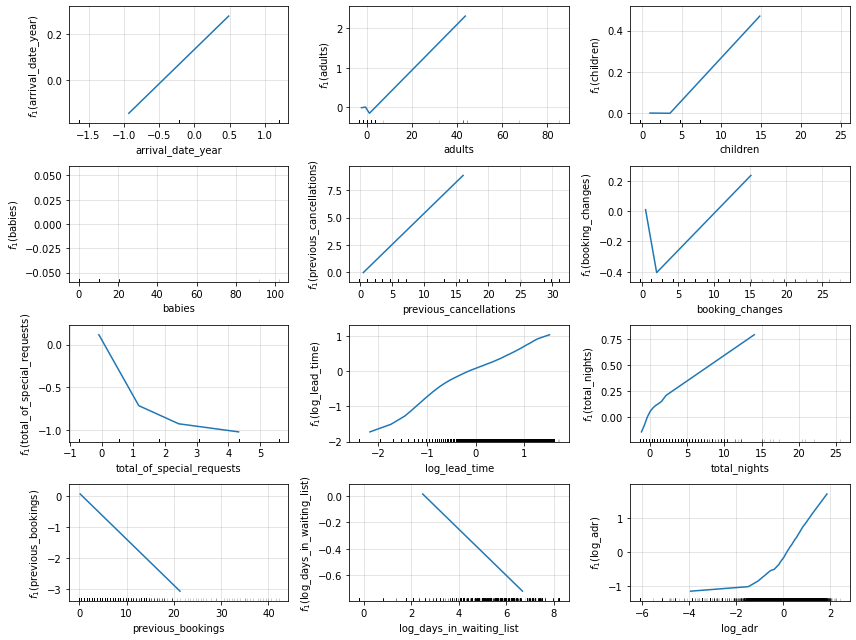

In [17]:
# 9 predictors, plotting in a 3x3 grid
num_rows=4
num_cols=3
fig,axs = plt.subplots(num_rows,num_cols,figsize=(12,9))
features = ["arrival_date_year","adults","children","babies",
           "previous_cancellations","booking_changes","total_of_special_requests",
          "log_lead_time","total_nights","previous_bookings",'log_days_in_waiting_list',
           'log_adr']
for i in range(num_rows):
    for j in range(num_cols):
        # select correct feature
        feature = features[num_cols*i + j]
        _ = first_order_aleplot_quant(log_odds_nnet,X_train,feature,bins=50,ax=axs[i,j])

fig.tight_layout()

The ranges of values of each numerical feature are

a) arrival_date_year -> 0.2 <br>
b) adults -> 2 <br>
c) children -> 0.4 <br>
d) babies -> 0 <br>
e) previous_cancellations -> 7.5 <br>
f) booking_changes ->0.6 <br>
g) total_of_special_requests -> 1 <br>
h) log_lead_time -> 3 <br>
i) total_nights -> 0.75 <br>
j) previous_bookings -> 3 <br>
h) log_days_in_waiting_list -> 0.6 <br>
i) log_adr -> 2 <br>


Babies, children and arrival_date_year do not seem to have a significant effect on the final value. Thus we can consider removing them. log_days_in_waiting_list and booking_changes have a low range but booking changes seem to have a non-linear relationship and log_days_in_waiting_list have closer ticks. So we keep these columns.

## Final iteration

In [24]:
## Second batch

np.random.seed(3)

clf_cv_init = MLPClassifier(
    ## archiecture hyperparameters ## 
    #hidden_layer_sizes=20, # scalar -> single hidden layer with 20 units
    activation='logistic', # activation function for the hidden layer
    alpha=0.001,# regularization parameter,
    solver='adam', # stochastic optimizer (default)
    learning_rate_init=0.001,# learning rate, controls the step size
    batch_size=512, # the number of samples considered in each iteration
    max_iter = 500, # number of epochs through the training set,
    #early_stopping=True, # monitor validation_loss and stop if there is no improvement
    #n_iter_no_change=10, # if validation loss doesn't improve for 10 epochs, terminate optimization
    #validation_fraction=0.1, # fraction of the dataset to set as aside as validation data,
    random_state=3,
    verbose=False
)

clf_final_4 = GridSearchCV(
    estimator = clf_cv_init,
    param_grid = { # dictionary containing possible values of each hyperparameter
        'hidden_layer_sizes':[30,50,70]
    },
    scoring='accuracy', # scoring metric - prediction accuracy
    refit=True,
    cv = KFold(n_splits=5,shuffle=True), # 1 replicate of 5-fold CV
    verbose=3
).fit(X_train_2,y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END .............hidden_layer_sizes=30;, score=0.857 total time=  31.9s
[CV 2/5] END .............hidden_layer_sizes=30;, score=0.858 total time=  37.3s
[CV 3/5] END .............hidden_layer_sizes=30;, score=0.858 total time=  34.6s
[CV 4/5] END .............hidden_layer_sizes=30;, score=0.860 total time=  36.5s
[CV 5/5] END .............hidden_layer_sizes=30;, score=0.858 total time=  37.4s
[CV 1/5] END .............hidden_layer_sizes=50;, score=0.862 total time= 6.0min


/Users/kiranjyothisheena/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END .............hidden_layer_sizes=50;, score=0.860 total time= 1.0min
[CV 3/5] END .............hidden_layer_sizes=50;, score=0.859 total time=  53.0s
[CV 4/5] END .............hidden_layer_sizes=50;, score=0.862 total time=  52.1s
[CV 5/5] END .............hidden_layer_sizes=50;, score=0.862 total time=  58.1s
[CV 1/5] END .............hidden_layer_sizes=70;, score=0.864 total time= 1.2min
[CV 2/5] END .............hidden_layer_sizes=70;, score=0.859 total time= 1.3min


/Users/kiranjyothisheena/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END .............hidden_layer_sizes=70;, score=0.861 total time= 4.0min
[CV 4/5] END .............hidden_layer_sizes=70;, score=0.863 total time= 1.2min


/Users/kiranjyothisheena/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END .............hidden_layer_sizes=70;, score=0.863 total time= 1.3min


/Users/kiranjyothisheena/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [25]:
print('Best parameters')
print(clf_final_4.best_params_)

print('Best CV accuracy: %.3f'%clf_final_4.best_score_)

Best parameters
{'hidden_layer_sizes': 70}
Best CV accuracy: 0.862


We go ahead with 50 hidden nodes.

In [27]:
## Refitting with parameters

X_train_2 = X_train.drop(["babies","children","arrival_date_year"],axis=1)
X_test_2 = X_test.drop(["babies","children","arrival_date_year"],axis=1)

np.random.seed(3)

clf_mlp_v1 = MLPClassifier(
    ## archiecture hyperparameters ## 
    hidden_layer_sizes=50, # scalar -> single hidden layer with 20 units
    activation='logistic', # activation function for the hidden layer
    alpha=0.001,# regularization parameter,
    solver='adam', # stochastic optimizer (default)
    learning_rate_init=0.001,# learning rate, controls the step size
    batch_size=512, # the number of samples considered in each iteration
    max_iter = 1000, # number of epochs through the training set,
    #early_stopping=True, # monitor validation_loss and stop if there is no improvement
    #n_iter_no_change=10, # if validation loss doesn't improve for 10 epochs, terminate optimization
    #validation_fraction=0.1, # fraction of the dataset to set as aside as validation data,
    random_state=3,
    verbose=False
)

clf_mlp_v1.fit(X_train_2,y_train)

MLPClassifier(activation='logistic', alpha=0.001, batch_size=512,
              hidden_layer_sizes=50, max_iter=1000, random_state=3)

In [28]:
### Testing with test dataset


y_pred_class = clf_mlp_v1.predict(X_test_2)

## Calculating the roc

conf_matrix = confusion_matrix(y_test, y_pred_class)


print('AUC score is ',roc_auc_score(y_test,y_pred_class))
misclass = (conf_matrix[0][1]+conf_matrix[1][0])/(sum(sum(conf_matrix)))
print('Misclass rate is ',misclass)

# --- Metrics---

print('\n--- EVALUATION METRICS ---:')
print('\nConfusion Matrix:')
print(conf_matrix)

print('\nClassification Report:')

print(classification_report(y_test,y_pred_class))


AUC score is  0.8476688354968392
Misclass rate is  0.13623989613435525

--- EVALUATION METRICS ---:

Confusion Matrix:
[[13686  1363]
 [ 1890  6938]]

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.91      0.89     15049
           1       0.84      0.79      0.81      8828

    accuracy                           0.86     23877
   macro avg       0.86      0.85      0.85     23877
weighted avg       0.86      0.86      0.86     23877



The accuracy actually decreased. So the final model we choose is 

MLPClassifier( <br>
    ## architecture hyperparameters ## <br>
    hidden_layer_sizes=50, # scalar -> single hidden layer with 20 units <br>
    activation='logistic', # activation function for the hidden layer <br>
    alpha=0.001,# regularization parameter,<br>
    solver='adam', # stochastic optimizer (default)<br>
    learning_rate_init=0.001,# learning rate, controls the step size <br>
    batch_size=512, # the number of samples considered in each iteration <br>
    max_iter = 500, # number of epochs through the training set, <br>
    random_state=3, <br>
    verbose=False <br>
)